In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM, Input, Multiply, Activation
from sklearn.metrics import root_mean_squared_error, mean_squared_error, r2_score, mean_absolute_error
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('E:/Final Dissertation/Cleaned_Dataset/PM2.5_sensor_and_council.csv')
data.head()

,Datetime,PM2.5_µg/m³_combustion_particles_organic_compounds_metals_sensor,PM2.5_µg/m³_council
0,2024-08-15 15:00:00,4.483333,4.8
1,2024-08-15 16:00:00,4.766667,3.8
2,2024-08-15 17:00:00,3.533333,7.1
3,2024-08-15 18:00:00,4.733333,6.4
4,2024-08-16 11:00:00,6.300000,3.8


In [3]:
X = data[['PM2.5_µg/m³_combustion_particles_organic_compounds_metals_sensor']].values
y = data['PM2.5_µg/m³_council'].values

| **Data** | **Split** |
|----------|-----------|
| **Train Set** | 70% of the Cleaned dataset |
| **Test Set** | 30% of the Cleaned dataset |

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
display(X_train[0:5])
print()
display(X_train_scaled[0:5])
print()
print()
display(X_test[0:5])
display(X_test_scaled[0:5])

array([[ 5.17647059],
       [15.83673469],
       [ 7.88235294],
       [18.33898305],
       [ 8.7       ]])

array([[-0.37955884],
       [ 2.37163311],
       [ 0.31877299],
       [ 3.01741125],
       [ 0.52979065]])

array([[0.75      ],
       [7.55      ],
       [3.8125    ],
       [1.01666667],
       [6.3       ]])

array([[-1.52193863],
       [ 0.23299962],
       [-0.73157122],
       [-1.45311752],
       [-0.08959932]])

In [7]:
def build_keras_model(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [8]:
def build_rnn_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(SimpleRNN(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(SimpleRNN(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [9]:
def build_gru_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()
    for i in range(layers):
        if i == 0:
            model.add(GRU(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(GRU(units[i], return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [10]:
def build_lstm_model(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    model = Sequential()

    for i in range(layers):
        if i == 0:
            model.add(LSTM(units[i], return_sequences=True if layers > 1 else False, input_shape=(1, 1)))
        else:
            model.add(LSTM(units[i], return_sequences=False))
    
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [11]:
def build_keras_model_with_attention(optimizer='adam', init='he_uniform', units=[64, 32], layers=2):
    model = Sequential()
    model.add(Dense(units[0], input_dim=1, kernel_initializer=init, activation='relu'))

    for i in range(1, layers):
        model.add(Dense(units[i], kernel_initializer=init, activation='relu'))
    
    attention = Dense(1, activation='tanh')(model.layers[-1].output)
    attention = Activation('softmax')(attention)
    attention = Multiply()([model.layers[-1].output, attention])
    
    model.add(Dense(1, kernel_initializer=init))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [12]:
def build_rnn_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    rnn_out = inputs
    for i in range(layers):
        rnn_out = SimpleRNN(units[i], return_sequences=True if layers > 1 else False)(rnn_out)
    
    attention = Dense(1, activation='tanh')(rnn_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([rnn_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [13]:
def build_gru_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    gru_out = inputs
    for i in range(layers):
        gru_out = GRU(units[i], return_sequences=True if layers > 1 else False)(gru_out)
    
    attention = Dense(1, activation='tanh')(gru_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([gru_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [14]:
def build_lstm_model_with_attention(optimizer='adam', init='he_uniform', units=[50, 50], layers=2):
    inputs = Input(shape=(1, 1))
    lstm_out = inputs
    
    for i in range(layers):
        lstm_out = LSTM(units[i], return_sequences=True if layers > 1 else False)(lstm_out)
    
    attention = Dense(1, activation='tanh')(lstm_out)
    attention = Activation('softmax')(attention)
    attention = Multiply()([lstm_out, attention])
    
    outputs = Dense(1)(attention)
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

## Experimented List of Models and Parameters

#### The MLPRegressor: This model optimizes the squared error using LBFGS or stochastic gradient descent.
#### The KerasRegressor: Wrapper that enables Keras models so that they can be used as part of a Scikit-Learn workflow

In [15]:
models = {
    'MLP Regressor': MLPRegressor(random_state=42, verbose=0),
    'Keras Regressor': KerasRegressor(build_fn=build_keras_model, verbose=0),
    'RNN Regressor': KerasRegressor(build_fn=build_rnn_model, verbose=0),
    'GRU Regressor': KerasRegressor(build_fn=build_gru_model, verbose=0),
    'LSTM Regressor': KerasRegressor(build_fn=build_lstm_model, verbose=0),
    'MLP Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'Keras Regressor with Attention': KerasRegressor(build_fn=build_keras_model_with_attention, verbose=0),
    'RNN Regressor with Attention': KerasRegressor(build_fn=build_rnn_model_with_attention, verbose=0),
    'GRU Regressor with Attention': KerasRegressor(build_fn=build_gru_model_with_attention, verbose=0),
    'LSTM Regressor with Attention': KerasRegressor(build_fn=build_lstm_model_with_attention, verbose=0),
}

params = {
    'MLP Regressor': {
        'hidden_layer_sizes': [(50, 50), (100,)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [200, 400],
    },
    'Keras Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'MLP Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'Keras Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'RNN Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'GRU Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    },
    'LSTM Regressor with Attention': {
        'optimizer': ['adam', 'rmsprop'],
        'batch_size': [10, 20],
        'epochs': [100, 50],
    }
}

#### 1. We prefer a Grid Search CV over a Random Search CV due to the small dataset size. As exhaustive hyperparameter tuning is necessary.
#### 2. neg_root_mean_squared_error is used for scoring, while R2 is used for selecting the best model under baseline models.

In [16]:
best_models = []

best_score = float('inf')
best_params = None
best_model_name = ''

for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    grid = GridSearchCV(estimator=model, param_grid=params[model_name], n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error', verbose=1)
    grid_result = grid.fit(X_train_scaled, y_train)
    
    try:
        best_models.append({
            'name': model_name,
            'model': grid_result.best_estimator_,
            'params': grid_result.best_params_,
            'rmse': -grid_result.best_score_
        })
    except (ValueError, NotFittedError) as e:
        print(f"Skipped {model_name} due to error: {str(e)}")

Training MLP Regressor...
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Training Keras Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training MLP Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training Keras Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training RNN Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training GRU Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Training LSTM Regressor with Attention...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


#### For showcasing model with the best R2

In [17]:
results = []
for model in best_models:
    result = {}
    result['name'] = model['name']
    result['params'] = model['params']
    test_predictions = model['model'].predict(X_test_scaled) 
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)
    
    result['rmse'] = test_rmse
    result['mse'] = test_mse
    result['r2'] = test_r2
    result['mae'] = test_mae
    result['comparison_df'] = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})
    results.append(result)

In [18]:
results = sorted(results, key=lambda x: x['r2'], reverse=True)

Results For Model: Keras Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 1.6240
Test MSE: 2.6374
Test R2: 0.8831
Test MAE: 1.3773


,Actual,Predicted
0,5.3,3.648784
1,5.0,5.680852
2,4.3,4.026999
3,6.3,3.602499
4,3.8,4.823468
5,6.3,6.729359
6,4.0,3.670647
7,2.0,3.605391
8,5.9,4.297143
9,7.4,4.518750


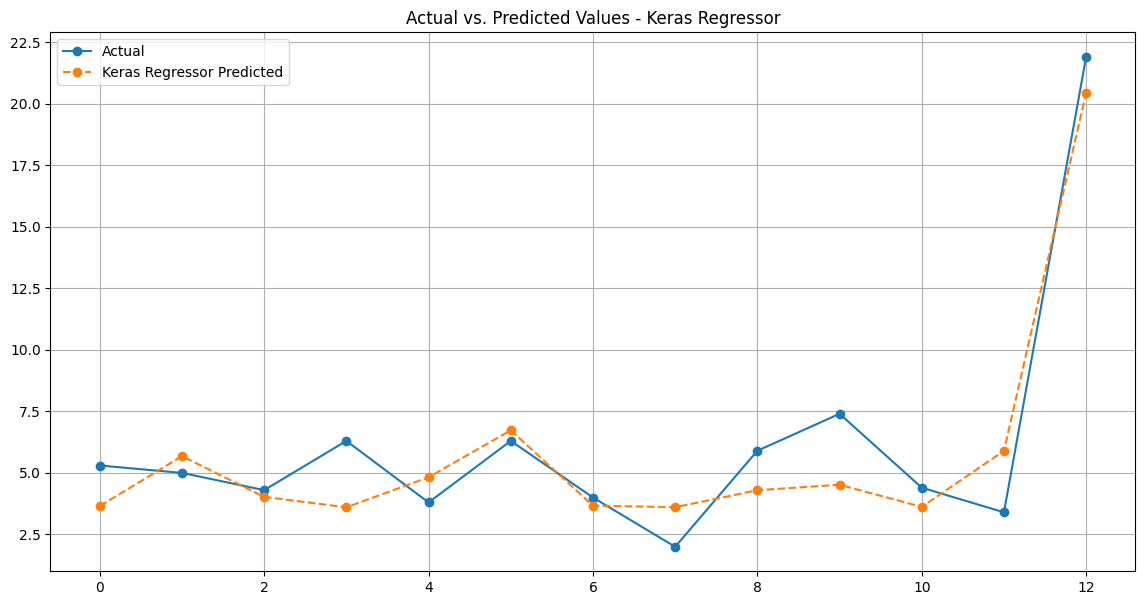


Results For Model: MLP Regressor
Best Hyperparameters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'adam'}
Test RMSE: 1.7636
Test MSE: 3.1104
Test R2: 0.8621
Test MAE: 1.5150


,Actual,Predicted
0,5.3,3.446414
1,5.0,6.028328
2,4.3,4.214242
3,6.3,3.496241
4,3.8,5.247235
5,6.3,7.020041
6,4.0,3.685472
7,2.0,3.492749
8,5.9,4.642979
9,7.4,4.924952


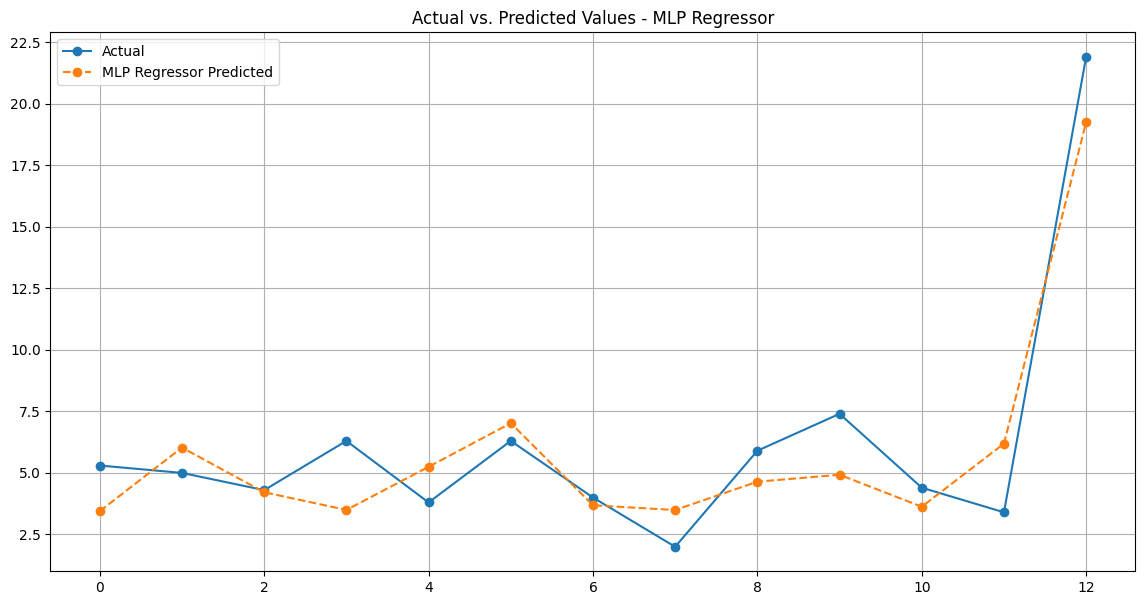


Results For Model: MLP Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 1.8356
Test MSE: 3.3694
Test R2: 0.8506
Test MAE: 1.6047


,Actual,Predicted
0,5.3,3.419307
1,5.0,6.340341
2,4.3,4.087375
3,6.3,3.420140
4,3.8,5.068114
5,6.3,7.178173
6,4.0,3.546679
7,2.0,3.418992
8,5.9,4.430958
9,7.4,4.715365


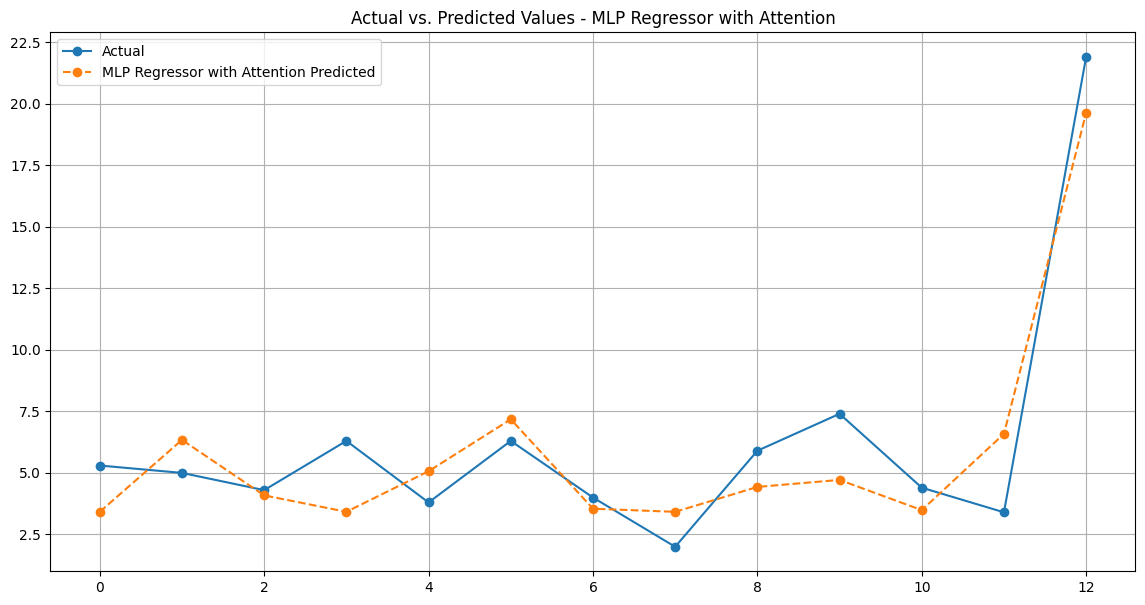


Results For Model: Keras Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 1.8531
Test MSE: 3.4341
Test R2: 0.8477
Test MAE: 1.6347


,Actual,Predicted
0,5.3,3.314233
1,5.0,6.167276
2,4.3,3.987634
3,6.3,3.301876
4,3.8,5.256906
5,6.3,7.235046
6,4.0,3.488605
7,2.0,3.302585
8,5.9,4.406090
9,7.4,4.722333


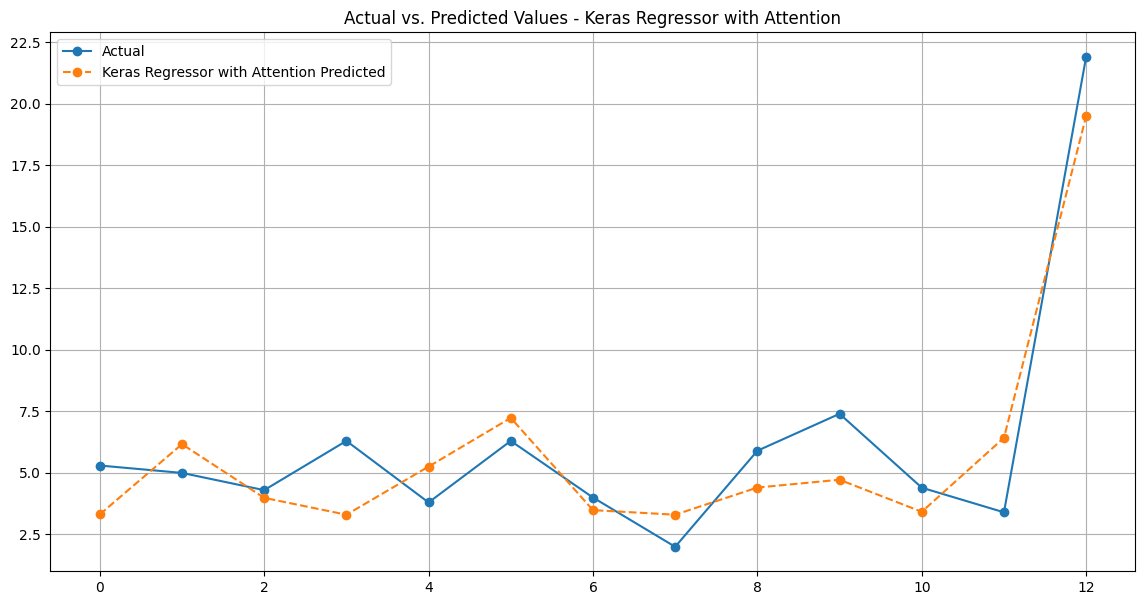


Results For Model: LSTM Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 50, 'optimizer': 'adam'}
Test RMSE: 2.0665
Test MSE: 4.2705
Test R2: 0.8106
Test MAE: 1.7133


,Actual,Predicted
0,5.3,3.151503
1,5.0,6.258537
2,4.3,4.333865
3,6.3,3.240668
4,3.8,5.557081
5,6.3,7.159568
6,4.0,3.566825
7,2.0,3.235020
8,5.9,4.863536
9,7.4,5.206217


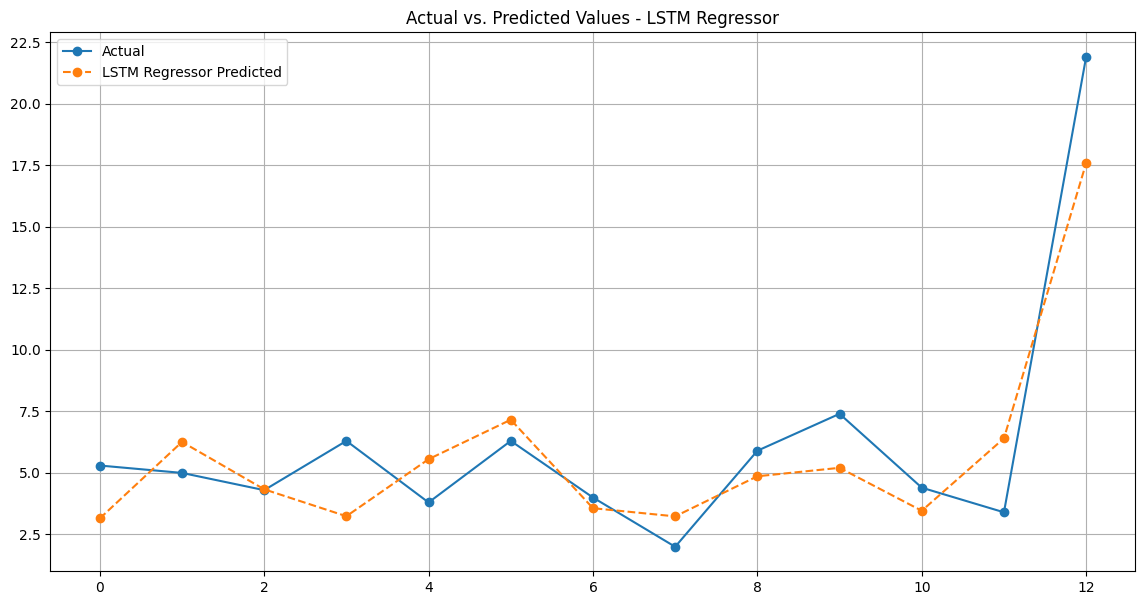


Results For Model: GRU Regressor
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 2.2002
Test MSE: 4.8410
Test R2: 0.7854
Test MAE: 1.7916


,Actual,Predicted
0,5.3,3.031688
1,5.0,6.243614
2,4.3,4.262047
3,6.3,3.124357
4,3.8,5.526303
5,6.3,7.155507
6,4.0,3.463778
7,2.0,3.118485
8,5.9,4.811302
9,7.4,5.165247


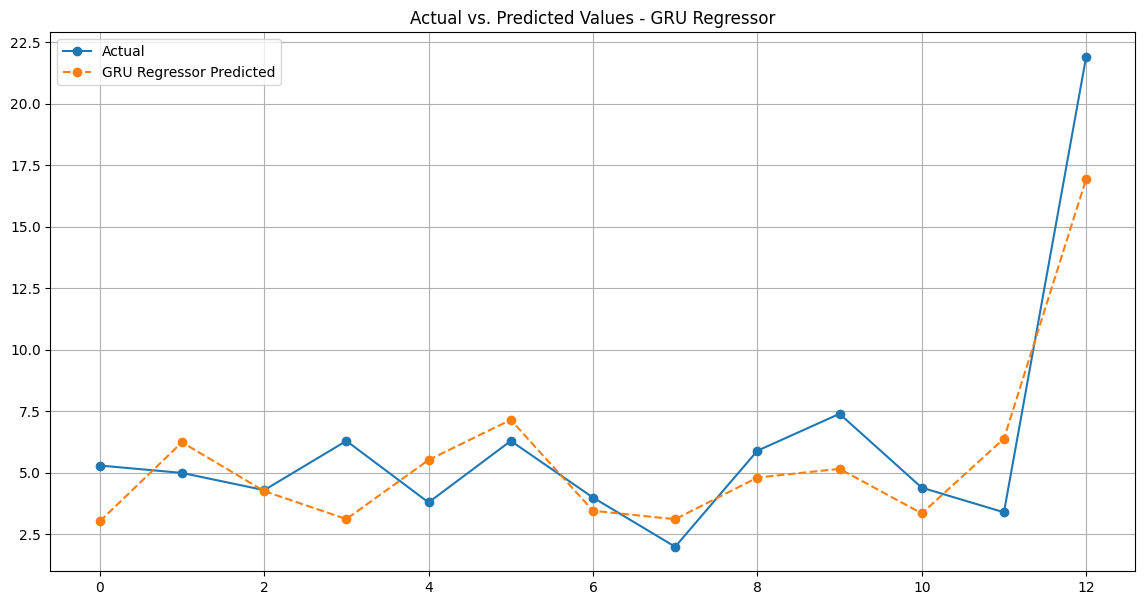


Results For Model: RNN Regressor
Best Hyperparameters: {'batch_size': 20, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 2.8827
Test MSE: 8.3098
Test R2: 0.6315
Test MAE: 2.1389


,Actual,Predicted
0,5.3,2.390013
1,5.0,6.493572
2,4.3,4.356581
3,6.3,2.568775
4,3.8,5.807929
5,6.3,7.278200
6,4.0,3.172894
7,2.0,2.557641
8,5.9,5.035485
9,7.4,5.431147


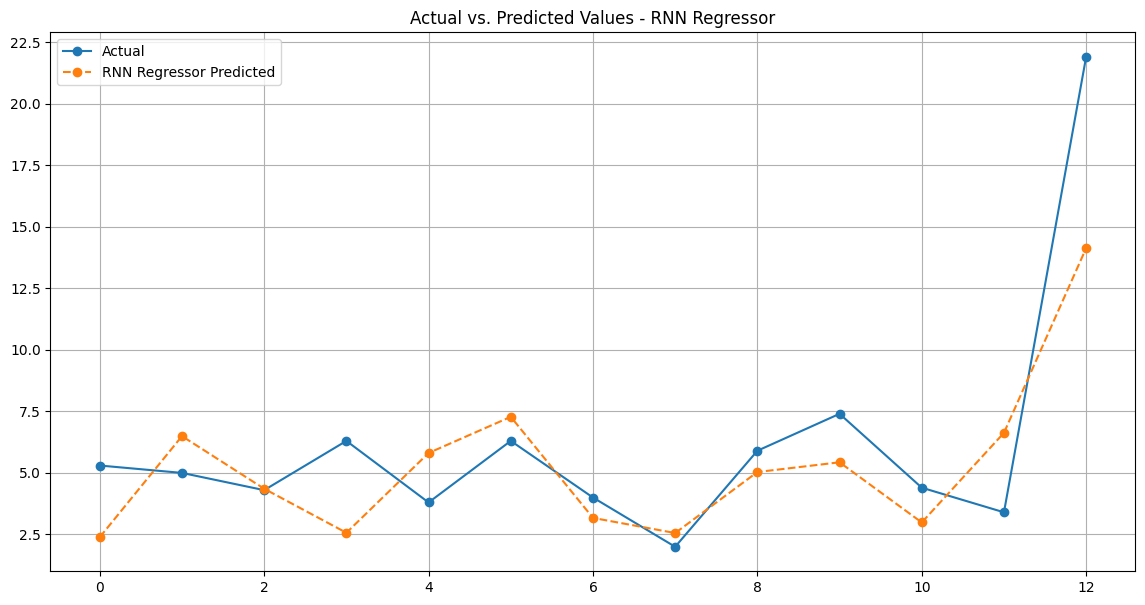


Results For Model: LSTM Regressor with Attention
Best Hyperparameters: {'batch_size': 10, 'epochs': 100, 'optimizer': 'rmsprop'}
Test RMSE: 4.1170
Test MSE: 16.9498
Test R2: 0.2485
Test MAE: 2.4114


,Actual,Predicted
0,5.3,6.288853
1,5.0,5.758270
2,4.3,5.871975
3,6.3,6.242113
4,3.8,5.746533
5,6.3,5.833889
6,4.0,6.095833
7,2.0,6.244979
8,5.9,5.789919
9,7.4,5.760584


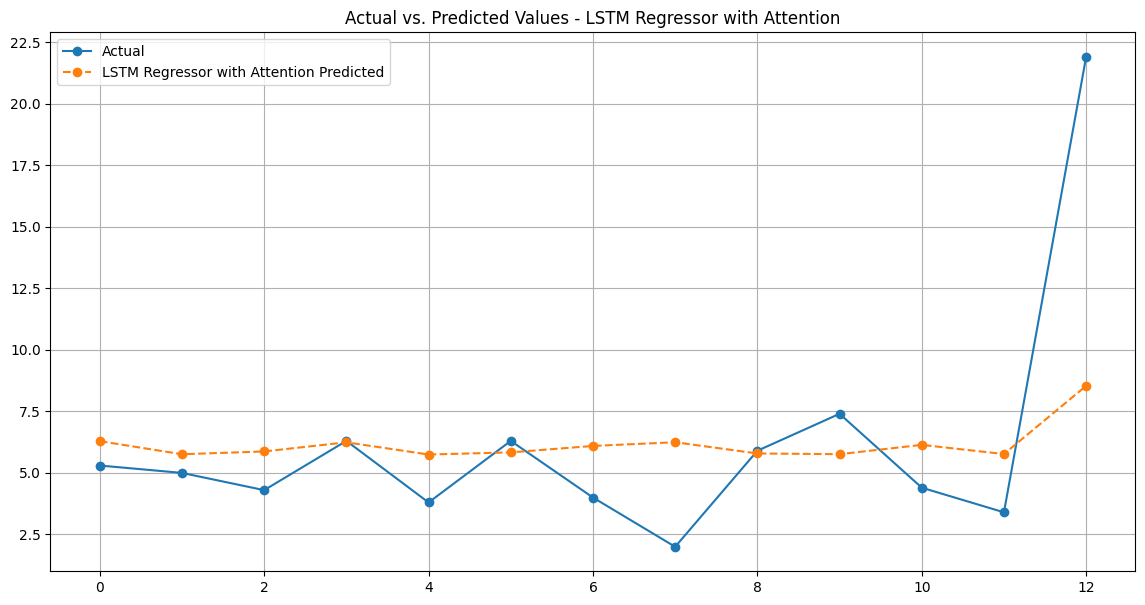


Results For Model: GRU Regressor with Attention
Best Hyperparameters: {'batch_size': 20, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 4.3928
Test MSE: 19.2969
Test R2: 0.1444
Test MAE: 2.4798


,Actual,Predicted
0,5.3,6.065811
1,5.0,5.921704
2,4.3,5.937343
3,6.3,6.050758
4,3.8,5.909161
5,6.3,5.959499
6,4.0,6.004467
7,2.0,6.051679
8,5.9,5.915720
9,7.4,5.909785


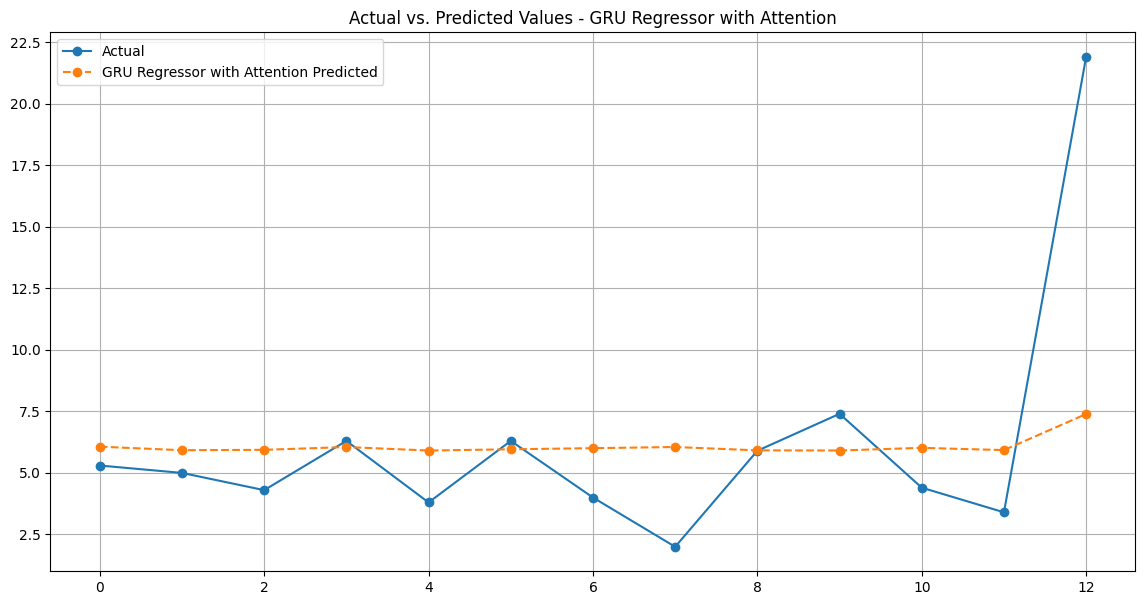


Results For Model: RNN Regressor with Attention
Best Hyperparameters: {'batch_size': 20, 'epochs': 100, 'optimizer': 'adam'}
Test RMSE: 4.9614
Test MSE: 24.6156
Test R2: -0.0914
Test MAE: 2.5952


,Actual,Predicted
0,5.3,5.544744
1,5.0,6.075501
2,4.3,5.920358
3,6.3,5.585083
4,3.8,6.062733
5,6.3,6.044493
6,4.0,5.713401
7,2.0,5.582601
8,5.9,6.004839
9,7.4,6.039980


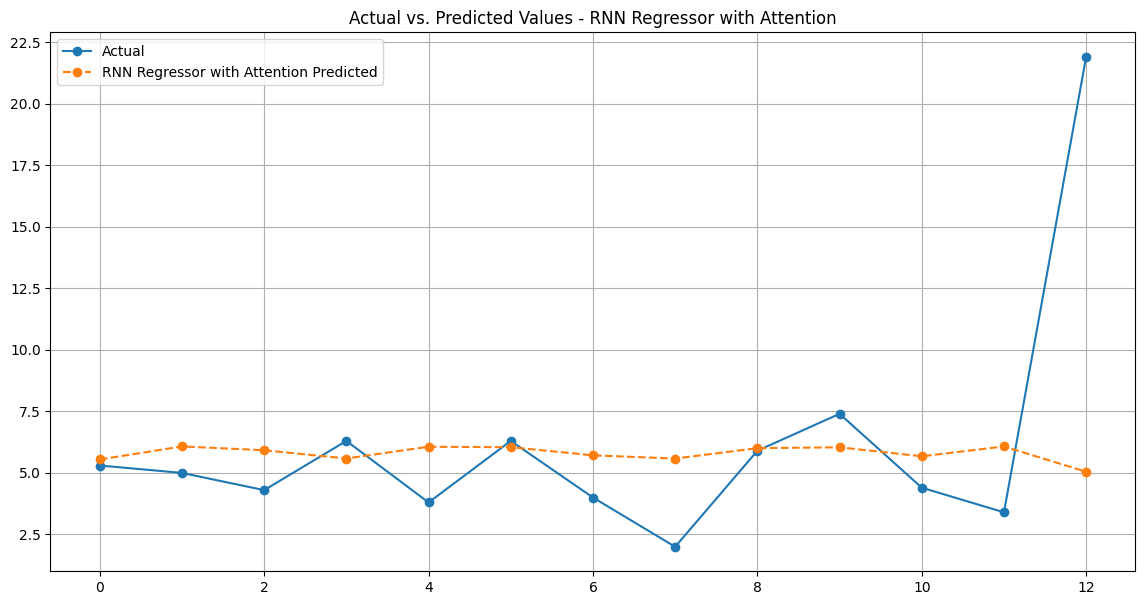

In [19]:
for result in results:
    model_name = result['name']
    print(f"Results For Model: {model_name}")
    print(f"Best Hyperparameters: {result['params']}")
    print(f"Test RMSE: {result['rmse']:.4f}")
    print(f"Test MSE: {result['mse']:.4f}")
    print(f"Test R2: {result['r2']:.4f}")
    print(f"Test MAE: {result['mae']:.4f}")

    comparison_df = result['comparison_df']
    display(comparison_df)

    plt.figure(figsize=(14, 7))
    plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', marker='o')
    plt.plot(comparison_df.index, comparison_df['Predicted'], label=f'{model_name} Predicted', linestyle='--', marker='o')
    plt.title(f'Actual vs. Predicted Values - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()
    print()

## Model Evaluation

In [20]:
final_scores_df = pd.DataFrame({
    'Model': [result['name'] for result in results],
    'RMSE': [result['rmse'] for result in results],
    'MSE': [result['mse'] for result in results],
    'R2': [result['r2'] for result in results],
    'MAE': [result['mae'] for result in results]
})

display(final_scores_df)

,Model,RMSE,MSE,R2,MAE
0,Keras Regressor,1.623997,2.637367,0.883060,1.377340
1,MLP Regressor,1.763637,3.110417,0.862086,1.515043
2,MLP Regressor with Attention,1.835580,3.369354,0.850605,1.604666
3,Keras Regressor with Attention,1.853129,3.434088,0.847734,1.634663
4,LSTM Regressor,2.066517,4.270492,0.810649,1.713304
5,GRU Regressor,2.200221,4.840973,0.785354,1.791579
6,RNN Regressor,2.882664,8.309754,0.631550,2.138931
7,LSTM Regressor with Attention,4.117008,16.949753,0.248456,2.411407
8,GRU Regressor with Attention,4.392823,19.296896,0.144385,2.479795
9,RNN Regressor with Attention,4.961414,24.615633,-0.091445,2.595211
